In [3]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from probcalkge import Experiment, ExperimentResult
from probcalkge import get_calibrators
from probcalkge import get_datasets,  get_kgemodels
from probcalkge import brier_score, negative_log_loss, ks_error, ece

In [4]:
cals = get_calibrators()
kges = get_kgemodels()
ds = get_datasets()

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [5]:
exp = Experiment(
    cals=[cals.uncal, cals.platt, cals.isot, ], 
    datasets=[ds.yago39], 
    kges=[ kges.distMult, kges.hoLE], 
    metrics=[ece]
    )

In [5]:
exp.train_kges()

training DistMult on YAGO39 ...


Average DistMult Loss:   0.375038: 100%|██████████| 100/100 [38:14<00:00, 22.95s/epoch]


training HolE on YAGO39 ...


Average HolE Loss:   0.774206: 100%|██████████| 100/100 [2:01:33<00:00, 72.94s/epoch] 


In [6]:
exp.save_trained_kges('../saved_models/newyago/')

made model directory: ../saved_models/newyago/
saved ../saved_models/newyago/YAGO39-DistMult.pkl.
saved ../saved_models/newyago/YAGO39-HolE.pkl.


In [7]:
exp = Experiment(
    cals=[cals.uncal, cals.platt, cals.isot, ], 
    datasets=[ds.yago39], 
    kges=[ kges.complEx], 
    metrics=[ece]
    )
exp.train_kges()
exp.save_trained_kges('../saved_models/newyago/')

training ComplEx on YAGO39 ...


Average ComplEx Loss:   0.165952: 100%|██████████| 100/100 [1:59:29<00:00, 71.70s/epoch] 


saved ../saved_models/newyago/YAGO39-ComplEx.pkl.


In [8]:
from ampligraph.latent_features import ComplEx
from ampligraph.utils import save_model, restore_model

# cpm1 = ComplEx(loss='nll', verbose=True)
# cpm1.fit(ds.fb13.X_train)
# save_model(cpm1, 'complex_nll.pkl')
cpm1 = restore_model('complex_nll.pkl')

# cpm2 = ComplEx(loss='absolute_margin', verbose=True)
# cpm2.fit(ds.fb13.X_train)
# save_model(cpm2, 'complex_margin.pkl')
cpm2 = restore_model('complex_margin.pkl')

0.5521026462160795


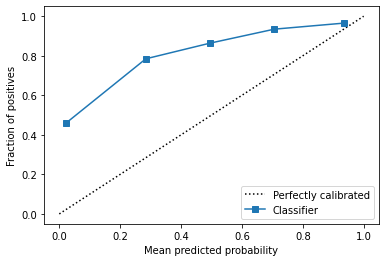

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibrationDisplay
from scipy.special import expit

scores1 = cpm1.predict(ds.fb13.X_test)
probs1 = expit(scores1)
print(accuracy_score(ds.fb13.y_test, probs1>0.5))
# plt.hist(probs1)
CalibrationDisplay.from_predictions(ds.fb13.y_test, probs1)

0.6154348558907804


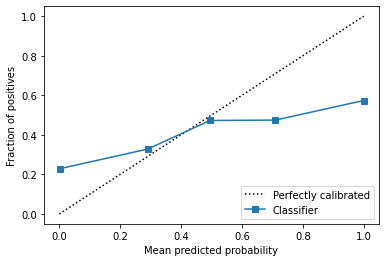

In [10]:
scores2 = cpm2.predict(ds.fb13.X_test)
probs2 = expit(scores2)
print(accuracy_score(ds.fb13.y_test, probs2>0.5))
# plt.hist(probs2)
CalibrationDisplay.from_predictions(ds.fb13.y_test, probs2)

0.6445937974043485


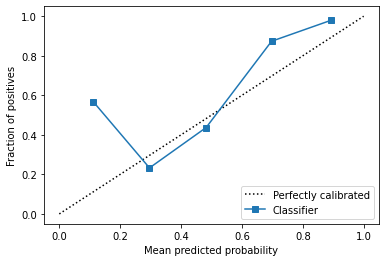

In [13]:
# cpm3 = ComplEx(loss='nll', verbose=True, regularizer='LP', regularizer_params={'p': 3, 'lambda':0.1})
# cpm3.fit(ds.fb13.X_train)
# save_model(cpm3, 'complex_nll_reg.pkl')
cpm3 = restore_model('complex_nll_reg.pkl')

scores3 = cpm3.predict(ds.fb13.X_test)
probs3 = expit(scores3)
print(accuracy_score(ds.fb13.y_test, probs3>0.5))
# plt.hist(probs3)
CalibrationDisplay.from_predictions(ds.fb13.y_test, probs3)

0.6102309118489803


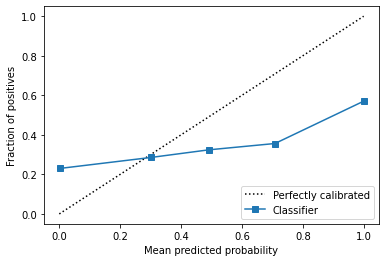

In [12]:
# cpm4 = ComplEx(loss='absolute_margin', verbose=True, regularizer='LP', regularizer_params={'p': 3, 'lambda':0.1})
# cpm4.fit(ds.fb13.X_train)
# save_model(cpm4, 'complex_mar_reg.pkl')
cpm4 = restore_model('complex_mar_reg.pkl')

scores4 = cpm4.predict(ds.fb13.X_test)
probs4 = expit(scores4)
print(accuracy_score(ds.fb13.y_test, probs4>0.5))
# plt.hist(probs4)
CalibrationDisplay.from_predictions(ds.fb13.y_test, probs4)

In [14]:
from probcalkge import brier_score

print(brier_score(ds.fb13.y_test, probs1))
print(brier_score(ds.fb13.y_test, probs2))
print(brier_score(ds.fb13.y_test, probs3))
print(brier_score(ds.fb13.y_test, probs4))

0.40882725364888817
0.3833788463040442
0.28289896739985426
0.3881478920725621
